In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("/home/sohel/Downloads/aptos2019-blindness-detection/"))
import cv2 
import PIL 
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.models import Sequential, Model
from keras.preprocessing import image  
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax
from keras.optimizers import Adam, rmsprop
from tqdm import tqdm
import gc
import psutil

['test.csv', 'test_images', 'sample_submission.csv', 'train.csv', 'train_images']


Using TensorFlow backend.


In [2]:
SEED=7
np.random.seed(SEED) 
set_random_seed(SEED)

In [3]:
df_train=pd.read_csv("/home/sohel/Downloads/aptos2019-blindness-detection/train.csv") 
df_test=pd.read_csv("/home/sohel/Downloads/aptos2019-blindness-detection/test.csv")

In [4]:
SEED=111
IMG_DIM=224 #512
BATCH_SIZE = 16
CHANNEL_SIZE=3
NB_EPOCHS=1
N_CLASSES = df_train['diagnosis'].nunique()
CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

In [5]:
df_train.columns, N_CLASSES

(Index(['id_code', 'diagnosis'], dtype='object'), 5)

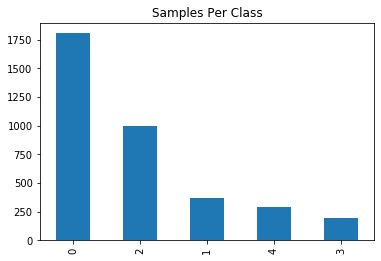

In [6]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');

In [7]:
x_train,x_test,y_train,y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.3, random_state =SEED, stratify=df_train.diagnosis)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((2563,), (2563,), (1099,), (1099,))

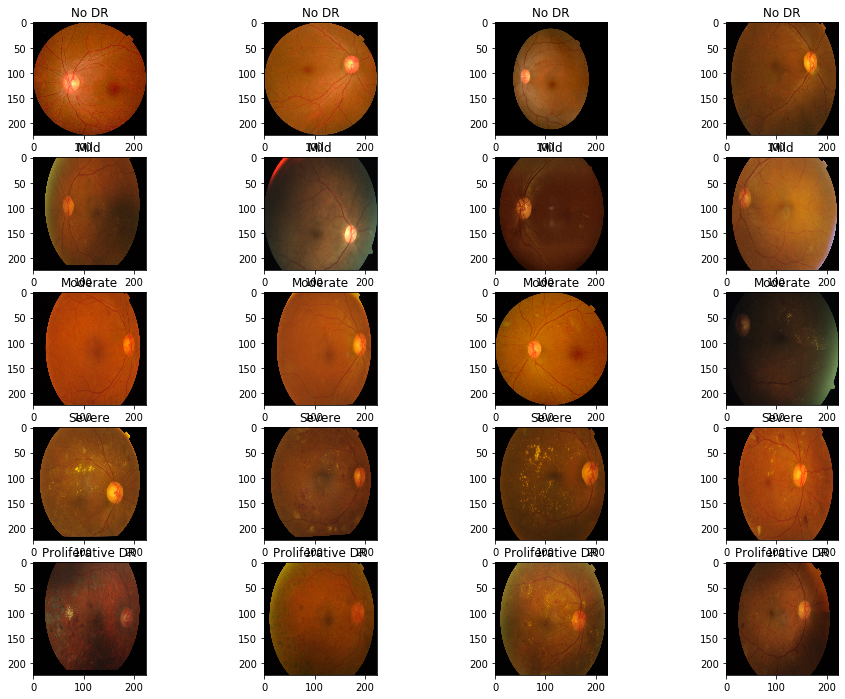

In [8]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(20,12))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/home/sohel/Downloads/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])
        #plt.show()

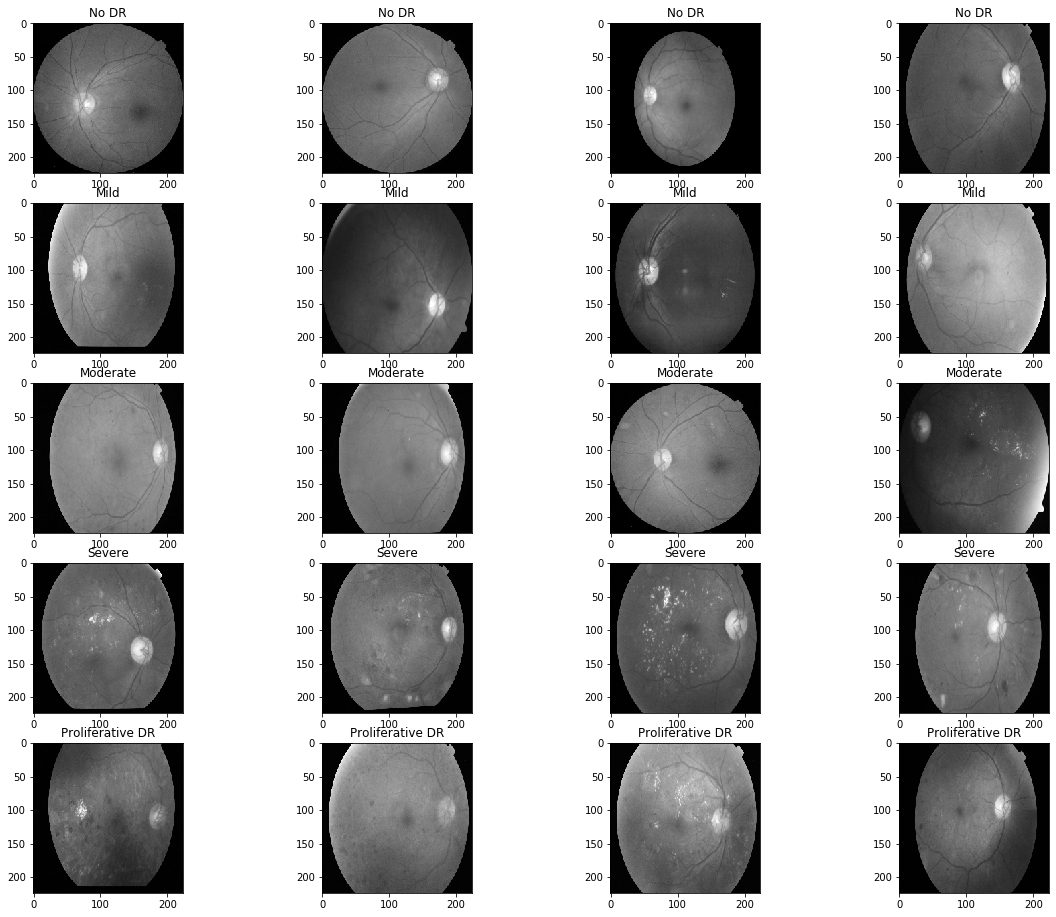

In [9]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/home/sohel/Downloads/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img,cmap='gray')
        ax.set_title(CLASSS[target_class])
#     plt.show()

(614, 819)
614 819


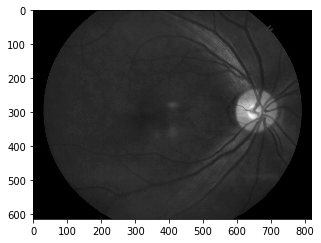

In [10]:
dpi =80 
imgPath=f"/home/sohel/Downloads/aptos2019-blindness-detection/train_images/0b00f8a77510.png"
# lower-right, this still looks not so severe, can be class3
img=cv2.imread(imgPath)
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
height, width=img.shape
print(height, width)
SCALE=2
figSize=(width/float(dpi))/SCALE,(height/float(dpi))/SCALE
fig=plt.figure(figsize=figSize)
plt.imshow(img, cmap="gray")

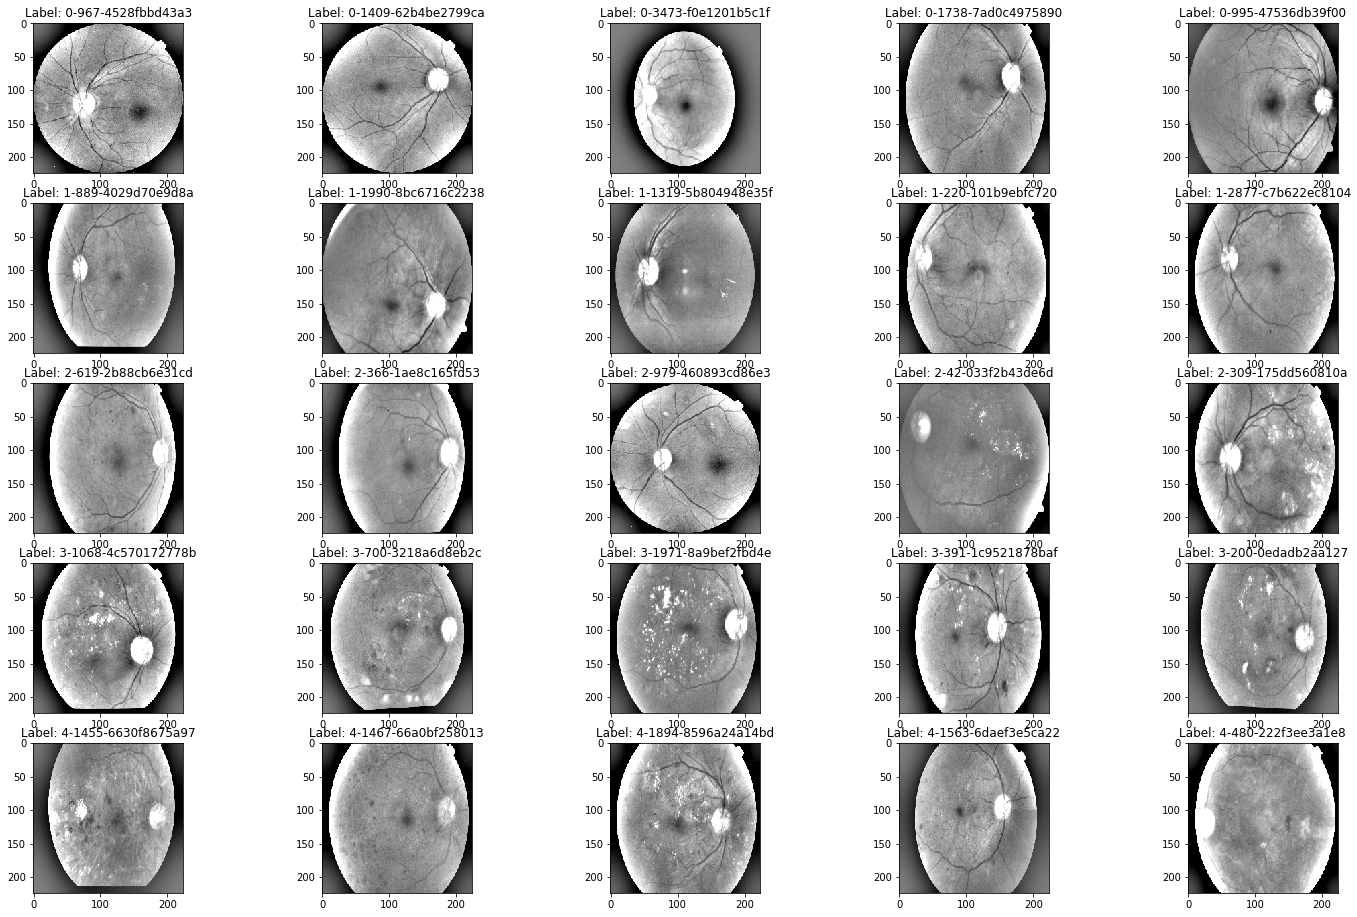

In [11]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(5, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"/home/sohel/Downloads/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        img=cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), IMG_DIM/10),-4, 128)
        plt.imshow(img,cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (target_class, idx, row['id_code']) )
#     plt.show()

In [12]:
print("available RAM:", psutil.virtual_memory())

gc.collect()

print("available RAM:", psutil.virtual_memory())

df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

available RAM: svmem(total=16774696960, available=14541537280, percent=13.3, used=1885659136, free=13169254400, active=2137051136, inactive=960315392, buffers=110751744, cached=1609031680, shared=40435712, slab=240455680)
available RAM: svmem(total=16774696960, available=14528032768, percent=13.4, used=1891430400, free=13155741696, active=2143895552, inactive=968015872, buffers=110751744, cached=1616773120, shared=48160768, slab=240492544)


In [13]:
train_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="/home/sohel/Downloads/aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training', seed=SEED
                                                 )
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="/home/sohel/Downloads/aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation', seed=SEED
                                                 )
del x_train 
# del x_test
del y_train
del y_test
gc.collect()

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


0

In [14]:
def design_model():
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=(2,2), input_shape=[IMG_DIM,IMG_DIM,CHANNEL_SIZE] , activation='relu'));
    model.add(MaxPooling2D(pool_size=(2,2)));
    model.add(Conv2D(filters=32,kernel_size=(2,2), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2,2)));
    model.add(Conv2D(filters=64,kernel_size=(2,2), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2,2)));
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation='relu', kernel_initializer='uniform'));
    model.add(Dropout(rate=0.3));
    model.add(Dense(units=1000, activation='relu', kernel_initializer='uniform'));
    model.add(Dropout(rate=0.3));
    model.add(Dense(5, activation='softmax'))
    return model

model=design_model()
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#checkpoint=ModelCheckpoint(filepath="/home/sohel/Downloads/weights.best.hdf5", verbose=1, save_best_only=True, monitor='val_loss', period=1)
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=0)

In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [17]:
from keras.layers import BatchNormalization

def create_resnet(img_dim,CHANNEL,n_class):
    input_tensor=Input(shape=(img_dim, img_dim,CHANNEL))
    base_model = ResNet50(weights=None,
                          include_top=False,
                          input_tensor=input_tensor)
    base_model.load_weights('/home/sohel/Videos/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x=GlobalAveragePooling2D()(base_model.output)
    x=Dropout(0.3)(x)
    x=Dense(1024, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    output_layer=Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet =Model(input_tensor, output_layer)
    return model_resnet
model_resnet=create_resnet(IMG_DIM,CHANNEL_SIZE, N_CLASSES)

/home/sohel/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [18]:
lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.2)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model.summary()
gc.collect()

365

In [19]:
history=model_resnet.fit_generator(generator=train_generator,
                           steps_per_epoch=STEP_SIZE_TRAIN,
                           validation_data=valid_generator,
                           validation_steps=STEP_SIZE_VALID,
                           epochs=NB_EPOCHS,
#                            shuffle=True,  
                           callbacks=[eraly_stop, reduce_lr],
                           verbose=1)
gc.collect()

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
183/183 [==============================] - 2319s 13s/step - loss: 0.9640 - acc: 0.6735 - val_loss: 0.7499 - val_acc: 0.7292


20

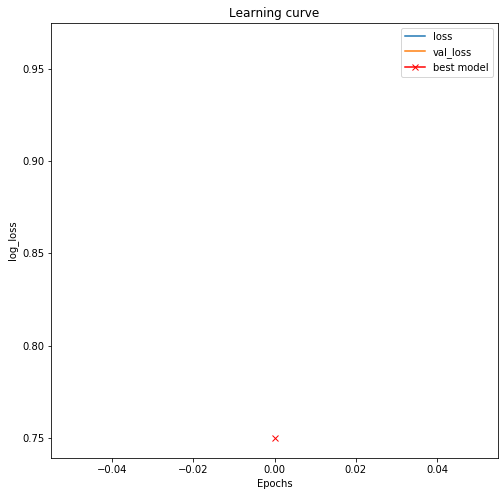

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [30]:
test_datagen=image.ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = "/home/sohel/Downloads/aptos2019-blindness-detection/test_images",
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=32,
                                                shuffle=False, 
                                                class_mode=categorical, seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

Found 1928 validated image filenames.
1928


2828

In [32]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

(eval_loss, eval_accuracy)=tqdm(model.evaluate(generator=valid_generator,steps=STEP_SIZE_TEST))

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

AttributeError: 'History' object has no attribute 'evaluate'